10


<AxesSubplot:xlabel='index'>

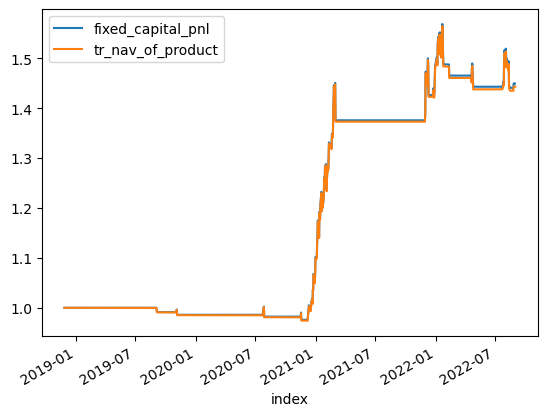

In [51]:
from ctse.sysdata.csv_ctse_strategy_backtest_data import csvCTSEStrategyBacktestData
from sysdata.csv.csv_multiple_prices import csvFuturesMultiplePricesData
import pandas as pd
import numpy as np
from ctse.sysobjects.ctse_strategy_backtest import ctseStrategyBacktest
from sysdata.csv.csv_instrument_data import csvFuturesInstrumentData
def select(se, start, end):
    return se[(se.index >= start) &(se.index <= end)]

ins = 'SP'
backtest = csvCTSEStrategyBacktestData().read('1_B', ins, 'dma_long', cols=[ctseStrategyBacktest.STATE_FLAG, ctseStrategyBacktest.NAV, ctseStrategyBacktest.OPERATE, ctseStrategyBacktest.OPEN])
backtest.loc[:, 'forecast'] = backtest[ctseStrategyBacktest.STATE_FLAG].replace(np.nan, 0)
fill = backtest.loc[backtest[ctseStrategyBacktest.OPERATE].replace(np.nan, '').str.contains('止损')]
backtest.loc[fill.index, 'adjusted_fill_price'] = fill[ctseStrategyBacktest.OPERATE].apply(lambda s: float(s.split('_')[-1]))

contract = csvFuturesMultiplePricesData('ctse.data.multiple_prices_csv')._get_multiple_prices_without_checking(ins, check_data=False)[['PRICE_CONTRACT', 'PRICE', 'CLOSE', 'FORWARD', 'CLOSE1']]

df = pd.concat([backtest, contract], axis=1)


config = csvFuturesInstrumentData('ctse.data.csvconfig')
pointsize = config.get_instrument_data(ins).meta_data.Pointsize
print(pointsize)


# routine for open pirce

# fill
df.loc[:, 'adjusted_fill_price'] = df['adjusted_fill_price'].shift(1)
df.loc[:, 'fill_price'] = df.adjusted_fill_price / df[ctseStrategyBacktest.OPEN].shift(1) * df['PRICE'].shift(1)
df.loc[df.fill_price.shift(-1).notna(), 'fill_price'] = df['PRICE']
df.loc[:, 'contract_pnl_at_fill'] = df['fill_price'].diff().shift(-1)

# rolling
df.loc[df['FORWARD'].notna(), 'FORWARD'] = df['CLOSE']
df.loc[df['FORWARD'].shift(-1).notna(), 'FORWARD'] = df.PRICE.shift(-1)
df.loc[df['CLOSE1'].shift(1).notna(), 'CLOSE1'] = df['PRICE']
df.loc[:, 'contract_pnl_at_rolling'] = df['FORWARD'].diff() + df['CLOSE1'].diff().shift(-1) * df.CLOSE / df.CLOSE1

# same contract
df.loc[:, 'same_contract_pnl'] = df['PRICE'].diff().shift(-1)


df.loc[:, 'contract_pnl_adjusted'] = df.loc[:, 'same_contract_pnl']
df.loc[df['contract_pnl_at_fill'].notna(), 'contract_pnl_adjusted'] = df['contract_pnl_at_fill']
df.loc[df['contract_pnl_at_rolling'].notna(), 'contract_pnl_adjusted'] = df['contract_pnl_at_rolling']

# pontsize
df.loc[:, 'contract_pnl_adjusted'] = df.contract_pnl_adjusted * pointsize
# df[df.contract_pnl_at_fill.notna()]
# select(df, '2015-05-07', '2015-05-18')
	
notional_capital = 1000_0000

df.loc[:, 'position'] = (df.forecast.shift(1) * notional_capital / (df.PRICE * pointsize))
df.loc[:, 'fixed_capital_pnl'] = (df.position * df.contract_pnl_adjusted)
t1 = (df.fixed_capital_pnl / notional_capital)
# t1 = select(t1, '2020-12-01', '2021-02-01')0
t2 = df.tr_nav_of_product.pct_change()
# t2 = select(t2, '2020-12-01', '2021-02-01')
# t1.plot(legend=True)
# t2.plot()
# display(select(pd.concat([t1, t2], axis=1), '2019-07-08', '2019-07-20'))
# display(select(df, '2019-07-08', '2019-07-20'))
(1+t1).cumprod().plot(legend=True)
(1+t2).cumprod().plot(legend=True)